In [1]:
!pip -q install -U keras-tuner gputil

import os
import time
import json
import platform
import numpy as np
import GPUtil
import pandas as pd
import tensorflow as tf
import gc
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeit

In [2]:
# Colab Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Paths
BASE_PATH = "/content/drive/MyDrive/EdgeMeter_AIv2/data"
WIN_KEY   = "48to12"
WIN_TAG   = "48_12"

HP_PATH_JSON = os.path.join(BASE_PATH, f"best_lipformer_hp_{WIN_KEY}.json")
TUNE_LOG_JSON= os.path.join(BASE_PATH, f"lipformer_tuning_log_{WIN_KEY}.json")
TRAIN_LOG    = os.path.join(BASE_PATH, "lipformer_training_log_48_12.json")


In [4]:
# Data
X_train = np.load(os.path.join(BASE_PATH, "X_train_48_12.npy"))
y_train = np.load(os.path.join(BASE_PATH, "y_train_48_12.npy"))
X_val   = np.load(os.path.join(BASE_PATH, "X_val_48_12.npy"))
y_val   = np.load(os.path.join(BASE_PATH, "y_val_48_12.npy"))
X_test  = np.load(os.path.join(BASE_PATH, "X_test_48_12.npy"))
y_test  = np.load(os.path.join(BASE_PATH, "y_test_48_12.npy"))

input_shape = X_train.shape[1:]   # (T, F)
T, F = input_shape

In [21]:
# GPU info
gpus = tf.config.list_physical_devices('GPU')
print("GPUs visible to TF:", gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except Exception:
        pass
gpu_name = GPUtil.getGPUs()[0].name if GPUtil.getGPUs() else "None"
print("GPU in use:", gpu_name)

GPUs visible to TF: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU in use: NVIDIA A100-SXM4-40GB
GPUs visible to TF: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU in use: NVIDIA A100-SXM4-40GB


In [22]:
# Load Best Hyperparameters
best_hps = None
if os.path.exists(HP_PATH_JSON):
    with open(HP_PATH_JSON, "r") as f:
        best_hps = json.load(f)
else:
    with open(TUNE_LOG_JSON, "r") as f:
        tune_log = json.load(f)
    best_hps = tune_log["best_hyperparameters"]

print("Best HPs:", best_hps)

Best HPs: {'patch_size': 12, 'embed_dim': 96, 'use_mha': True, 'num_heads': 4, 'key_dim': 48, 'attn_dropout': 0.1, 'ff_dim': 128, 'ff_dropout': 0.1, 'learning_rate': 0.0001}
Best HPs: {'patch_size': 12, 'embed_dim': 96, 'use_mha': True, 'num_heads': 4, 'key_dim': 48, 'attn_dropout': 0.1, 'ff_dim': 128, 'ff_dropout': 0.1, 'learning_rate': 0.0001}


In [23]:
# LiPFormer V2
def patchify(x, patch_size):
    # (B, T, F) -> (B, P, patch_size*F), P = floor(T/patch_size)
    T_ = tf.shape(x)[1]
    F_ = tf.shape(x)[2]
    t_trim = (T_ // patch_size) * patch_size
    x = x[:, :t_trim, :]
    P = t_trim // patch_size
    return tf.reshape(x, [tf.shape(x)[0], P, patch_size * F_])

def lipformer_block(x, hp_dict):
    """V1 LiPFormer idea + V2 upgrades (PreNorm, bigger FFN, dropout, optional MHA)."""
    embed_dim   = int(hp_dict["embed_dim"])
    use_mha     = bool(hp_dict["use_mha"])
    attn_drop   = float(hp_dict["attn_dropout"])
    ff_dim      = int(hp_dict["ff_dim"])
    ff_dropout  = float(hp_dict["ff_dropout"])

    # Project patches to stable embed size
    x = layers.Dense(embed_dim)(x)

    # PreNorm + Attention
    y = layers.LayerNormalization(epsilon=1e-6)(x)
    if use_mha:
        num_heads = int(hp_dict["num_heads"])
        key_dim   = int(hp_dict["key_dim"])
        y = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=key_dim, dropout=attn_drop
        )(y, y)
    else:
        # Lightweight 'linear' attention path
        q = layers.Dense(embed_dim)(y)
        k = layers.Dense(embed_dim)(y)
        v = layers.Dense(embed_dim)(y)
        scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))
        attn = tf.nn.softmax(tf.matmul(q, k, transpose_b=True) / scale, axis=-1)
        y = tf.matmul(attn, v)
        if attn_drop > 0.0:
            y = layers.Dropout(attn_drop)(y)
    x = layers.Add()([x, y])  # residual

    # PreNorm + FFN
    y = layers.LayerNormalization(epsilon=1e-6)(x)
    y = layers.Dense(ff_dim, activation="gelu")(y)
    if ff_dropout > 0.0:
        y = layers.Dropout(ff_dropout)(y)
    y = layers.Dense(embed_dim)(y)
    x = layers.Add()([x, y])  # residual
    return x

def build_lipformer_from_hp(input_shape, hp_dict):
    T, F = input_shape
    patch_size = int(hp_dict["patch_size"])
    assert T // patch_size > 0, f"patch_size {patch_size} too large for T={T}"

    inputs = keras.Input(shape=(T, F))
    x = layers.Lambda(lambda t: patchify(t, patch_size))(inputs)  # (B, P, patch_size*F)
    x = lipformer_block(x, hp_dict)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(12)(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=float(hp_dict["learning_rate"])),
        loss="mse",
        metrics=["mae"]
    )
    return model

model = build_lipformer_from_hp(input_shape, best_hps)
model.summary()

# Callbacks
early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=5,min_delta=5e-4, restore_best_weights=True)
reduce_lr  = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 4, 132)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4, 96)     │     12,768 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 4, 96)     │        192 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 4, 96)     │     74,400 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 4, 96)     │          0 │ dense[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 4, 96)     │        192 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4, 128)    │     12,416 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 4, 128)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4, 96)     │     12,384 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 4, 96)     │          0 │ add[0][0],        │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 96)        │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 12)        │      1,164 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 113,516 (443.42 KB)

 Trainable params: 113,516 (443.42 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 4, 132)    │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 4, 96)     │     12,768 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 4, 96)     │        192 │ dense_4[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 4, 96)     │     74,400 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 4, 96)     │          0 │ dense_4[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 4, 96)     │        192 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4, 128)    │     12,416 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 4, 128)    │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 4, 96)     │     12,384 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 4, 96)     │          0 │ add_2[0][0],      │
│                     │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 96)        │          0 │ add_3[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 12)        │      1,164 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 113,516 (443.42 KB)

 Trainable params: 113,516 (443.42 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train
start_time = time.time()
device = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"
with tf.device(device):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=512,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
end_time = time.time()

Epoch 1/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 124s 5ms/step - loss: 0.2790 - mae: 0.2339 - val_loss: 0.0521 - val_mae: 0.1324 - learning_rate: 1.0000e-04
Epoch 2/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - loss: 0.0514 - mae: 0.1231 - val_loss: 0.0462 - val_mae: 0.1143 - learning_rate: 1.0000e-04
Epoch 3/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - loss: 0.0476 - mae: 0.1172 - val_loss: 0.0449 - val_mae: 0.1224 - learning_rate: 1.0000e-04
Epoch 4/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - loss: 0.0461 - mae: 0.1152 - val_loss: 0.0439 - val_mae: 0.1179 - learning_rate: 1.0000e-04
Epoch 5/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - loss: 0.0452 - mae: 0.1137 - val_loss: 0.0431 - val_mae: 0.1130 - learning_rate: 1.0000e-04
Epoch 6/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - loss: 0.0446 - mae: 0.1126 - val_loss: 0.0430 - val_mae: 0.1107 - learning_rate: 1.0000e-04
Epoch 7/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - loss: 0.0442 - mae: 0.1118 - val_l

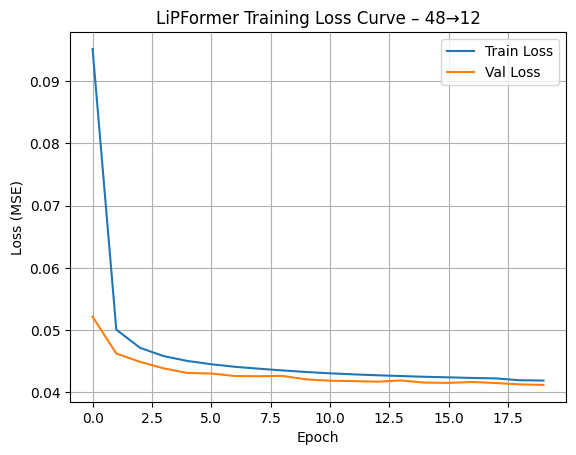

In [9]:
# Saving Training History & Curve
hist_df = pd.DataFrame(history.history)
hist_df.to_csv(os.path.join(BASE_PATH, "LiPFormer_Training_History_48_12.csv"))

plt.figure()
plt.plot(hist_df["loss"], label="Train Loss")
plt.plot(hist_df["val_loss"], label="Val Loss")
plt.title("LiPFormer Training Loss Curve – 48→12")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(BASE_PATH, "LiPFormer_Training_Curve_48_12.png"))
plt.show()

In [10]:
# Saving Weights
WEIGHTS_PATH = os.path.join(BASE_PATH, "LiPFormer_48_12_trained.weights.h5")
model.save_weights(WEIGHTS_PATH)
print(f" Saved GPU-trained weights to {WEIGHTS_PATH}")

 Saved GPU-trained weights to /content/drive/MyDrive/EdgeMeter_AIv2/data/LiPFormer_48_12_trained.weights.h5


In [11]:
# Evaluation
y_pred = model.predict(X_test, batch_size=1024, verbose=0)
test_mae  = mean_absolute_error(y_test, y_pred)
mse       = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(mse)
test_r2   = r2_score(y_test, y_pred)

In [12]:
# Export Formats
SAVE_DIR   = os.path.join(BASE_PATH, "Final_LiPFormer_Model_48_12")
SAVE_H5    = os.path.join(BASE_PATH, "Final_LiPFormer_Model_48_12.h5")
SAVE_KERAS = os.path.join(BASE_PATH, "Final_LiPFormer_Model_48_12.keras")

model.export(SAVE_DIR)   # TF SavedModel (Keras 3)
model.save(SAVE_H5)      # HDF5
model.save(SAVE_KERAS)   # .keras

Saved artifact at '/content/drive/MyDrive/EdgeMeter_AIv2/data/Final_LiPFormer_Model_48_12'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 11), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  135997648702352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997648712528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997648703696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997648704080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997648703888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997648710608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997648712720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997648710800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997648713488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997648713296: TensorSpec(shape=

In [13]:
# Model Size
def get_dir_size_mb(path):
    total_size = 0
    for dirpath, _, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.isfile(fp):
                total_size += os.path.getsize(fp)
    return total_size / 1e6

size_savedmodel_mb = get_dir_size_mb(SAVE_DIR)
size_h5_mb    = os.path.getsize(SAVE_H5) / 1e6 if os.path.exists(SAVE_H5) else None
size_keras_mb = os.path.getsize(SAVE_KERAS) / 1e6 if os.path.exists(SAVE_KERAS) else None


   usage_bin       MAE      RMSE        R2
0          0  0.046880  0.098837  0.175290
1          1  0.068331  0.128388  0.202384
2          2  0.088212  0.158820  0.278307
3          3  0.132062  0.236997  0.294448
4          4  0.214822  0.357793  0.714935


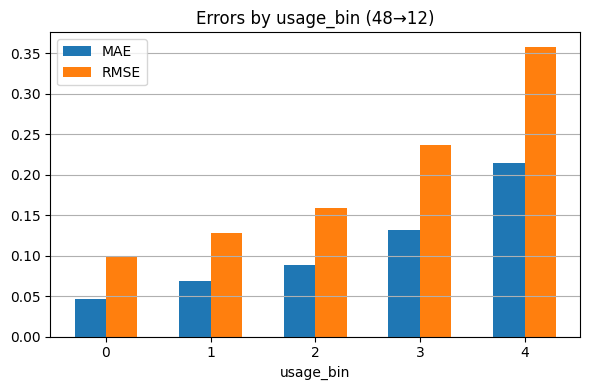

In [14]:
# Error by usage bin
USAGE_BIN_IDX = 10
bins = X_test[:, -1, USAGE_BIN_IDX].astype(int)
rows = []
for b in np.sort(np.unique(bins)):
    m = (bins == b)
    yt, yp = y_test[m], y_pred[m]
    if yt.size == 0:
        continue
    rows.append({
        'usage_bin': int(b),
        'MAE': mean_absolute_error(yt, yp),
        'RMSE': np.sqrt(mean_squared_error(yt, yp)),
        'R2': r2_score(yt, yp)
    })
by_bin = pd.DataFrame(rows).sort_values('usage_bin')
by_bin_csv = os.path.join(BASE_PATH, "LiPFormer_metrics_by_usage_bin_48_12.csv")
by_bin.to_csv(by_bin_csv, index=False)
print(by_bin)

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(by_bin['usage_bin']-0.15, by_bin['MAE'],  width=0.3, label='MAE')
ax.bar(by_bin['usage_bin']+0.15, by_bin['RMSE'], width=0.3, label='RMSE')
ax.set_xlabel('usage_bin'); ax.set_title('Errors by usage_bin (48→12)')
ax.grid(True, axis='y'); ax.legend()
fig.tight_layout()
fig.savefig(os.path.join(BASE_PATH, "LiPFormer_errors_by_usage_bin_48_12.png"))
plt.show()

In [15]:
# Residual diagnostics by hour‑of‑day
HOUR_IDX = 5
hours    = np.rint(X_test[:, -1, HOUR_IDX] * 23).astype(int).clip(0,23)
resid    = (y_test - y_pred).reshape(len(y_test), 12)
abs_res  = np.abs(resid).mean(axis=1)

df_hr = pd.DataFrame({'hour': hours, 'abs_resid': abs_res})
by_hr = df_hr.groupby('hour', as_index=False)['abs_resid'].mean()
by_hr_csv = os.path.join(BASE_PATH, "LiPFormer_abs_residual_by_hour_48_12.csv")
by_hr.to_csv(by_hr_csv, index=False)
print(by_hr.head())

   hour  abs_resid
0     0   0.064987
1    23   0.111041


In [16]:
# Inference Time
sample_input = tf.convert_to_tensor(X_test[:1])
t0 = timeit.default_timer(); _ = model(sample_input); t1 = timeit.default_timer()
inference_time = (t1 - t0) * 1000.0

In [17]:
# Log Final Metrics
gpus = GPUtil.getGPUs()
log_data = {
    "model_name": "LiPFormer_Final_48_12",
    "task": "Smart Meter Energy Forecasting",
    "tuning_type": "BayesianOptimization",
    "test_mae": float(test_mae),
    "test_rmse": float(test_rmse),
    "test_r2": float(test_r2),
    "params": int(model.count_params()),
    "model_size_mb_savedmodel": float(size_savedmodel_mb),
    "model_size_mb_h5": float(size_h5_mb) if size_h5_mb is not None else None,
    "model_size_mb_keras": float(size_keras_mb) if size_keras_mb is not None else None,
    "inference_time_ms": float(inference_time),
    "training_time_minutes": round((end_time - start_time) / 60, 2),
    "input_shape": list(map(int, X_train.shape[1:])),
    # LiPFormer-specific HPs (same keys as tuning)
    "patch_size":    int(best_hps["patch_size"]),
    "embed_dim":     int(best_hps["embed_dim"]),
    "use_mha":       bool(best_hps["use_mha"]),
    "num_heads":     (int(best_hps["num_heads"]) if best_hps["use_mha"] else None),
    "key_dim":       (int(best_hps["key_dim"])   if best_hps["use_mha"] else None),
    "attn_dropout":  float(best_hps["attn_dropout"]),
    "ff_dim":        int(best_hps["ff_dim"]),
    "ff_dropout":    float(best_hps["ff_dropout"]),
    "learning_rate": float(best_hps["learning_rate"]),
    "system_info": {
        "platform": platform.system(),
        "platform_version": platform.version(),
        "processor": platform.processor(),
        "gpu_used": gpus[0].name if gpus else "None"
    }
}
with open(os.path.join(BASE_PATH, "LiPFormer_Final_Log_48_12.json"), "w") as f:
    json.dump(log_data, f, indent=4)

In [18]:
# Saving Predictions
np.savetxt(os.path.join(BASE_PATH, "LiPFormer_y_pred_48_12.csv"), y_pred, delimiter=",")


In [19]:
# CPU rebuild + TFLite (edge-ready)
tf.keras.backend.clear_session()
gc.collect()
try:
    tf.config.experimental.set_visible_devices([], 'GPU')
    print(" GPU hidden for CPU rebuild.")
except Exception as e:
    print("⚠ Could not hide GPU (not critical):", e)

with tf.device("/CPU:0"):
    cpu_model = build_lipformer_from_hp(input_shape, best_hps)
    cpu_model.load_weights(WEIGHTS_PATH)

SAVE_DIR_CPU = os.path.join(BASE_PATH, "Final_LiPFormer_Model_48_12_CPU_clean")
cpu_model.export(SAVE_DIR_CPU)
print(" CPU-only SavedModel at:", SAVE_DIR_CPU)

converter = tf.lite.TFLiteConverter.from_saved_model(SAVE_DIR_CPU)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
try:
    tflite_model = converter.convert()
except Exception as e:
    print("Builtins-only failed, retrying with SELECT_TF_OPS. Error:", e)
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    tflite_model = converter.convert()

TFLITE_PATH = os.path.join(BASE_PATH, "Final_LiPFormer_Model_48_12.tflite")
with open(TFLITE_PATH, "wb") as f:
    f.write(tflite_model)
print(f" TFLite model saved at: {TFLITE_PATH}")

⚠ Could not hide GPU (not critical): Visible devices cannot be modified after being initialized


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/content/drive/MyDrive/EdgeMeter_AIv2/data/Final_LiPFormer_Model_48_12_CPU_clean'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 11), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  135997598437008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997598437584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997598440272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997598437200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997598440080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997598437392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997598441232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997598438736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997598439888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997598439504: TensorS

In [20]:
# Quick TFLite sanity check
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()
inp = interpreter.get_input_details()[0]
out = interpreter.get_output_details()[0]
sample = X_test[:1].astype(np.float32)
interpreter.set_tensor(inp["index"], sample)
interpreter.invoke()
pred = interpreter.get_tensor(out["index"])
print("TFLite inference OK | Output shape:", pred.shape)
print("First prediction row:", pred[0])

TFLite inference OK | Output shape: (1, 12)
First prediction row: [0.12331089 0.10716736 0.1130963  0.11006793 0.08479659 0.12696852
 0.14135802 0.12371489 0.13470641 0.13087617 0.09250707 0.13781482]


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
